In [47]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import talib as ta
import mplfinance as mpl
import bt

###Download the index and stock data

nifty = yf.download("^NSEI", start = "2008-01-01", end = "2022-06-22")

stocks = pd.read_csv("C:/Users/amolk/Desktop/stocks-ffn.csv", index_col = ["Date"], parse_dates = ["Date"])


[*********************100%***********************]  1 of 1 completed


In [69]:
#Calculate returns and plot the histogram
returns = stocks.to_log_returns().dropna()

ax = returns.hist(figsize=(12, 5))
plt.show()

                 ACC  ADANIENT  ADANIPORTS  AMBUJACEM  APOLLOHOSP  ASIANPAINT  \
Date                                                                            
2008-02-01 -0.005167  0.048796    0.008140  -0.004047    0.001800    0.001938   
2008-03-01 -0.015862  0.004292   -0.024505  -0.020141   -0.030561    0.002417   
2008-04-01 -0.007276 -0.003030   -0.028180  -0.011445   -0.001155    0.001623   
2008-07-01  0.002198 -0.013050   -0.010618  -0.005596   -0.020346    0.060784   
2008-08-01 -0.016657 -0.025720   -0.018462  -0.003866   -0.021498    0.029101   

            AXISBANK  BAJAJHLDNG  BAJFINANCE  BANKBARODA  ...  TATAMOTORS  \
Date                                                      ...               
2008-02-01  0.061897   -0.001709    0.069008    0.020931  ...    0.040111   
2008-03-01  0.001159   -0.008220   -0.027934    0.014730  ...   -0.002460   
2008-04-01  0.018224    0.005699    0.117983   -0.022385  ...   -0.012649   
2008-07-01  0.032869   -0.023132   -0.028782   

<module 'matplotlib.pyplot' from 'C:\\Users\\amolk\\AppData\\Roaming\\Python\\Python38\\site-packages\\matplotlib\\pyplot.py'>

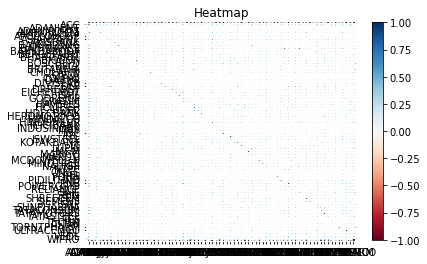

In [80]:
returns.plot_corr_heatmap()

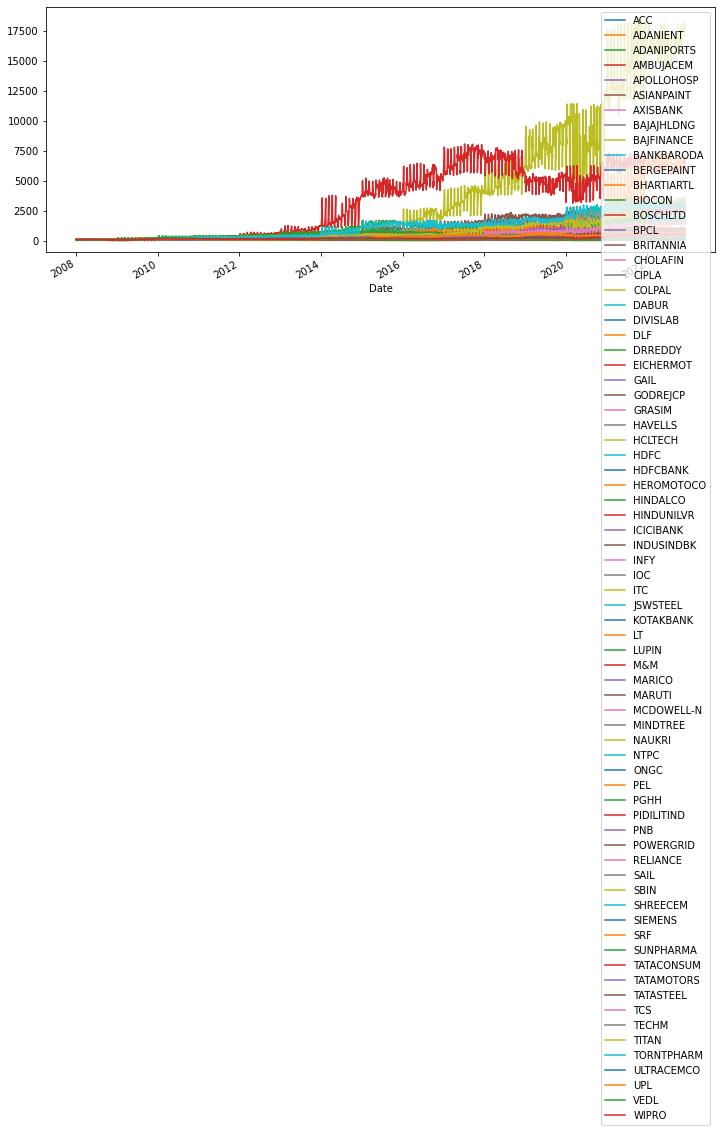

In [77]:
ax = stocks.rebase().plot(figsize=(12,5))

In [54]:
#calculate sma50 and plot overlay

sma = stocks.rolling(50).mean()

plot = bt.merge(stocks, sma).plot(figsize=(15, 5))
plt.show()

In [58]:
#intiate the backtest engine 
class SelectWhere(bt.Algo):

    """
    Selects securities based on an indicator DataFrame.

    Selects securities where the value is True on the current date (target.now).

    Args:
        * signal (DataFrame): DataFrame containing the signal (boolean DataFrame)

    Sets:
        * selected

    """
    def __init__(self, signal):
        self.signal = signal

    def __call__(self, target):
        # get signal on target.now
        if target.now in self.signal.index:
            sig = self.signal.loc[target.now]

            # get indices where true as list
            selected = list(sig.index[sig])

            # save in temp - this will be used by the weighing algo
            target.temp['selected'] = selected

        # return True because we want to keep on moving down the stack
        return True

In [59]:
#Create the trading signal
signal = stocks > sma

In [60]:
s = bt.Strategy('above50sma', [SelectWhere(stocks > sma),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])

# create the Backtest
t = bt.Backtest(s, stocks)

# Run the backtest
res = bt.run(t)

In [63]:
#Display and plot backtest results
res.plot()
plt.show()

res.display()

Stat                 above50sma
-------------------  ------------
Start                2007-12-31
End                  2022-06-05
Risk-free rate       0.00%

Total Return         625.05%
Daily Sharpe         0.75
Daily Sortino        1.17
CAGR                 14.73%
Max Drawdown         -58.52%
Calmar Ratio         0.25

MTD                  -1.21%
3m                   6.15%
6m                   -0.86%
YTD                  -4.27%
1Y                   19.88%
3Y (ann.)            26.83%
5Y (ann.)            17.41%
10Y (ann.)           18.26%
Since Incep. (ann.)  14.73%

Daily Sharpe         0.75
Daily Sortino        1.17
Daily Mean (ann.)    92.49%
Daily Vol (ann.)     122.76%
Daily Skew           0.68
Daily Kurt           22.19
Best Day             77.68%
Worst Day            -56.97%

Monthly Sharpe       0.77
Monthly Sortino      1.48
Monthly Mean (ann.)  15.80%
Monthly Vol (ann.)   20.51%
Monthly Skew         0.42
Monthly Kurt         3.75
Best Month           30.78%
Worst Month      

In [67]:
#Compare with nifty benchmark
import ffn
prices = ffn.calc_stats(nifty.Close)
prices.display()

Stats for Close from 2008-01-01 00:00:00 - 2022-06-21 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
154.52%             0.41  6.67%   -59.86%

Annualized Returns:
mtd     3m      6m      ytd     1y      3y      5y      10y     incep.
------  ------  ------  ------  ------  ------  ------  ------  --------
-5.70%  -8.64%  -6.75%  -9.88%  -0.68%  10.08%  10.18%  11.72%  6.67%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.41     0.47       0.62
mean    9.08%    10.06%     14.77%
vol     22.06%   21.37%     23.72%
skew    0.05     -0.31      1.01
kurt    15.22    4.60       2.71
best    17.74%   28.07%     75.76%
worst   -12.98%  -26.41%    -24.62%

Drawdowns:
max      avg       # days
-------  ------  --------
-59.86%  -3.48%     53.26

Misc:
---------------  ------
avg. up month    4.74%
avg. down month  -4.03%
up year %        78.57%
